MLP and SVM CV_Coursework.ipynb/Code

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CV_Coursework/CW_Folder_PG/CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset', 'Video', 'Models', 'Code', 'test_functions.ipynb']


In [4]:
## LAB 07

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset')

Zip_path1 = os.path.join(zip_path, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{Zip_path1}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [5]:
import cv2
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow
import torch.optim as optim
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import recall_score, roc_auc_score, precision_score, roc_curve, auc
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, learning_curve
import pickle 
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [ ]:
# Reference: Lab 7 code is manipulated in a way to load our data.

def import_data(path):
  files = [file for file in sorted(os.listdir(path)) if file.endswith('.jpg')]
  images = [cv2.imread(os.path.join(path, file)) for file in files]
  f = open("labels/list_label_" + path + ".txt", "r")
  labels = [row.split(' ')[1][0] for row in f]
  
  return images, labels

In [ ]:
X_train, y_train = import_data("train")
X_test, y_test = import_data("test")

In [ ]:
X_train[0]

array([[[ 73,  74,  65],
        [103, 104,  95],
        [ 76,  75,  71],
        ...,
        [ 27,  22,  23],
        [ 77,  72,  73],
        [ 64,  60,  59]],

       [[125, 126, 117],
        [ 92,  93,  84],
        [ 72,  71,  67],
        ...,
        [ 55,  51,  50],
        [ 93,  88,  85],
        [ 51,  48,  44]],

       [[ 58,  59,  50],
        [ 86,  87,  78],
        [ 82,  81,  77],
        ...,
        [ 64,  61,  53],
        [ 80,  74,  67],
        [ 40,  37,  29]],

       ...,

       [[ 22,  19,  14],
        [ 19,  16,  11],
        [ 17,  16,  12],
        ...,
        [155, 169, 191],
        [157, 171, 193],
        [158, 172, 194]],

       [[ 10,   7,   2],
        [ 15,  12,   7],
        [ 20,  19,  15],
        ...,
        [155, 169, 191],
        [158, 172, 194],
        [158, 172, 194]],

       [[ 12,   9,   4],
        [ 18,  15,  10],
        [ 24,  23,  19],
        ...,
        [156, 170, 192],
        [158, 172, 194],
        [158, 172, 194]]

## SVM-HOG

In [ ]:
# REFERENCE-Lab  6
# Create empty lists for feature descriptors and labels for train
len_x_train = len(X_train)
hog_images = []
hog_labels = []
ppc=16
for i in range(len_x_train):
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    fd, hog_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
    hog_images.append(hog_image)
    hog_labels.append(fd)

In [ ]:
print('HOG descriptor shape =', fd.shape)

HOG descriptor shape = (288,)


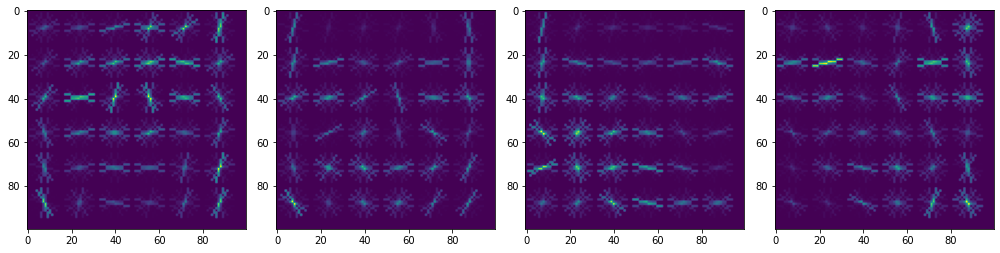

In [ ]:
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,5):
  plt.subplot(1,4,i)
  plt.imshow(hog_images[random.randint(1,1000)])

plt.tight_layout()
plt.show()

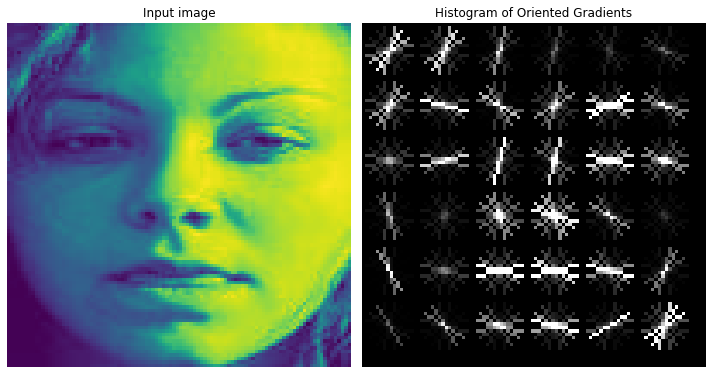

In [ ]:
## Reference LAB 6
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax[0].axis('off')
ax[0].imshow(img)
ax[0].set_title('Input image')

# Rescale histogram for better display
HOG_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax[1].axis('off')
ax[1].imshow(HOG_image_rescaled, cmap='gray')
ax[1].set_title('Histogram of Oriented Gradients')
fig.tight_layout()
plt.show()

In [ ]:
# Create a classifier: a support vector classifier
classifier = SVC()

In [ ]:
hog_labels = np.array(hog_labels)

In [ ]:
classifier.fit(hog_labels, y_train)

SVC()

In [ ]:
# Create empty lists for feature descriptors and labels for train
len_x_test = len(X_test)
hog_test = []
for i in range(len_x_test):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    fd, hog_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
    hog_test.append(fd)

hog_test1 = np.vstack(hog_test)   

In [ ]:
y_pred = classifier.predict(hog_test1)

<function matplotlib.pyplot.show>

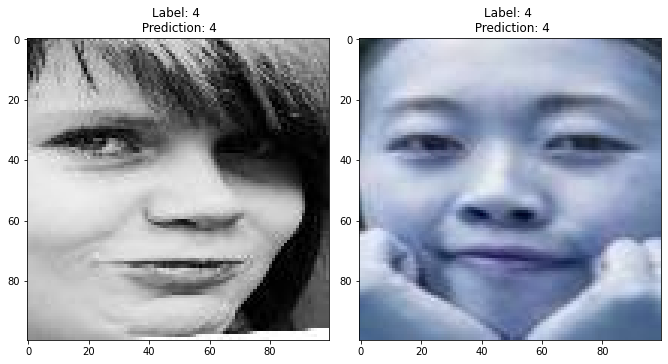

In [ ]:
# REFERENCE-Lab  6
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,3):
  x = random.randint(1,100)
  plt.subplot(1,3,i)
  plt.imshow(X_test[x])
  plt.title(f'Label: {y_test[x]} \n Prediction: {y_pred[x]}')

plt.tight_layout()
plt.show

In [ ]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.63      0.51      0.57       329
           2       0.91      0.14      0.24        74
           3       0.55      0.04      0.07       160
           4       0.72      0.88      0.79      1185
           5       0.52      0.44      0.48       478
           6       0.68      0.31      0.42       162
           7       0.57      0.71      0.63       680

    accuracy                           0.64      3068
   macro avg       0.65      0.43      0.46      3068
weighted avg       0.64      0.64      0.61      3068




## Grid Search Implementation

In [ ]:
paramtercheck = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10], 'gamma':[1, 0.1, 0.01]}
model_svm = GridSearchCV(SVC(), paramtercheck, verbose=3,cv=3)

In [ ]:
model_svm.fit(hog_labels, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.606 total time=   9.7s
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.596 total time=   9.5s
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.574 total time=   9.0s
[CV 1/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.573 total time=  16.7s
[CV 2/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.581 total time=  16.8s
[CV 3/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.545 total time=  15.3s
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.389 total time=  25.5s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.389 total time=  25.1s
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.389 total time=  25.6s
[CV 1/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.606 total time=   9.6s
[CV 2/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.596 total time=   9.7s
[CV 3/3] END ...C=0.1, gamma=0.1, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=3)

In [ ]:
best_svm_hog = "/content/drive/MyDrive/CV_Coursework/CW_Folder_PG/CW_Folder_PG/Models/SVM_HOG.pickle"

with open(best_svm_hog, mode ="wb") as f:
    pickle.dump(model_svm, f)

In [ ]:
best_svm_hog = "/content/drive/MyDrive/CV_Coursework/CW_Folder_PG/CW_Folder_PG/Models/SVM_HOG.pickle"

with open(best_svm_hog, "rb") as f:
    SVM_trained = pickle.load(f)

In [ ]:
print(SVM_trained.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
means = SVM_trained.cv_results_['mean_test_score']
stds = SVM_trained.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, SVM_trained.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.592 (+/-0.027) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.566 (+/-0.031) for {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.389 (+/-0.000) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.592 (+/-0.027) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
0.605 (+/-0.035) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.515 (+/-0.012) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.592 (+/-0.027) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
0.389 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.391 (+/-0.007) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.589 (+/-0.037) for {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.566 (+/-0.031) for {'C': 1, 'gamma': 1, 'kernel': 'poly'}
0.481 (+/-0.017) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.589 (+/-0.037) for {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
0.594 (+/-0.033) for {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
0.606 (+/-0.032) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.589 (+/-0.037) for {'C': 1, 'gamma': 0.01, 'kernel': '

In [ ]:
y_pred_param = SVM_trained.predict(hog_test1)

<function matplotlib.pyplot.show>

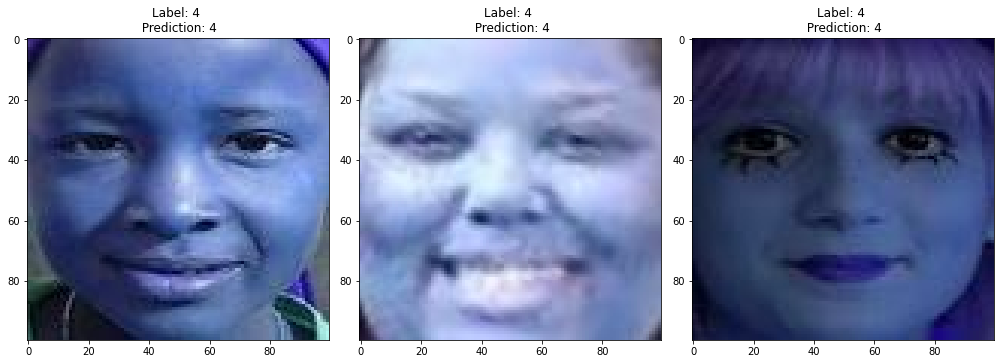

In [ ]:
# REFERENCE-Lab  6
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,4):
  x = random.randint(1,100)
  plt.subplot(1,3,i)
  plt.imshow(X_test[x])
  plt.title(f'Label: {y_test[x]} \n Prediction: {y_pred_param[x]}')

plt.tight_layout()
plt.show

In [ ]:
print(f"""Classification report for classifier {SVM_trained}:
      {metrics.classification_report(y_test, y_pred_param)}\n""")

Classification report for classifier GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=3):
                    precision    recall  f1-score   support

           1       0.61      0.49      0.54       329
           2       1.00      0.09      0.17        74
           3       0.50      0.02      0.04       160
           4       0.71      0.88      0.79      1185
           5       0.51      0.42      0.46       478
           6       0.68      0.31      0.43       162
           7       0.57      0.70      0.63       680

    accuracy                           0.63      3068
   macro avg       0.65      0.42      0.44      3068
weighted avg       0.63      0.63      0.60      3068




## MLP-HOG

In [ ]:
MLP_model = MLPClassifier(max_iter=1000)

In [ ]:
MLP_model.fit(hog_labels, y_train)

MLPClassifier(max_iter=1000)

In [ ]:
mlp_ypred = MLP_model.predict(hog_test1)

In [ ]:
print(f"""Classification report for classifier {MLP_model}:
      {metrics.classification_report(y_test, mlp_ypred)}\n""")

Classification report for classifier MLPClassifier(max_iter=1000):
                    precision    recall  f1-score   support

           1       0.52      0.44      0.48       329
           2       0.32      0.22      0.26        74
           3       0.22      0.15      0.18       160
           4       0.76      0.75      0.75      1185
           5       0.44      0.40      0.42       478
           6       0.38      0.45      0.41       162
           7       0.52      0.63      0.57       680

    accuracy                           0.58      3068
   macro avg       0.45      0.43      0.44      3068
weighted avg       0.57      0.58      0.57      3068




<function matplotlib.pyplot.show>

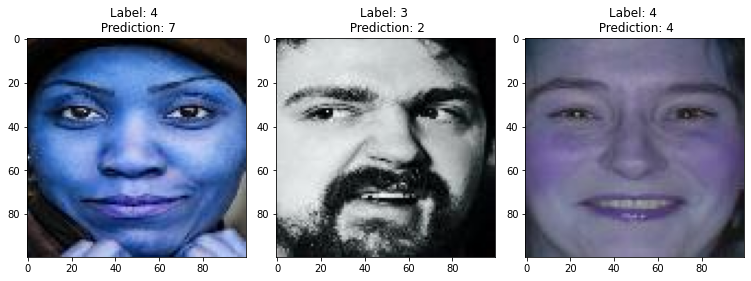

In [ ]:
# REFERENCE-Lab  6
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,4):
  x = random.randint(1,100)
  plt.subplot(1,4,i)
  plt.imshow(X_test[x])
  plt.title(f'Label: {y_test[x]} \n Prediction: {mlp_ypred[x]}')

plt.tight_layout()
plt.show

In [6]:
parameters={'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp_param =GridSearchCV(MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(3,3), alpha=1e-5), parameters, n_jobs=-1, cv=5)

In [ ]:
mlp_param.fit(hog_labels, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3, 3),
                                     max_iter=1000, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [ ]:
best_mlp_hog = "/content/drive/MyDrive/CV_Coursework/CW_Folder_PG/CW_Folder_PG/Models/MLP_HOG.pickle"

with open(best_mlp_hog, mode ="wb") as f:
    pickle.dump(mlp_param, f)

In [ ]:
best_mlp_hog = "/content/drive/MyDrive/CV_Coursework/CW_Folder_PG/CW_Folder_PG/Models/MLP_HOG.pickle"

with open(best_mlp_hog, "rb") as f:
    MLP_trained = pickle.load(f)

In [ ]:
print(MLP_trained.best_params_)

{'activation': 'identity', 'solver': 'lbfgs'}


In [ ]:
mlp_pred_param = MLP_trained.predict(hog_test1)

In [ ]:
print(f"""Classification report for classifier {MLP_trained}:
      {metrics.classification_report(y_test, mlp_pred_param)}\n""")

Classification report for classifier GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3, 3),
                                     max_iter=1000, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'solver': ['lbfgs', 'sgd', 'adam']}):
                    precision    recall  f1-score   support

           1       0.53      0.50      0.51       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.70      0.86      0.77      1185
           5       0.40      0.38      0.39       478
           6       0.41      0.27      0.32       162
           7       0.54      0.59      0.56       680

    accuracy                           0.59      3068
   macro avg       0.37      0.37      0.37      3068
weighted avg       0.53      0.59      0.56      3068




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show>

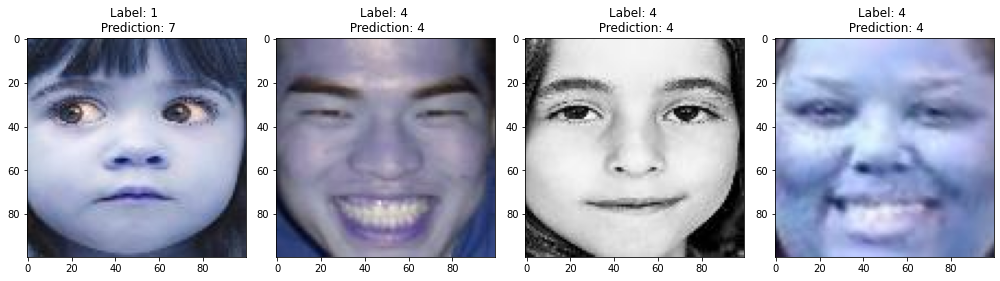

In [ ]:
# REFERENCE-Lab  6
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,5):
  x = random.randint(1,100)
  plt.subplot(1,4,i)
  plt.imshow(X_test[x])
  plt.title(f'Label: {y_test[x]} \n Prediction: {mlp_pred_param[x]}')

plt.tight_layout()
plt.show